In [2]:
from IPython.display import Image
import os
from scipy import misc
from scipy import ndimage
from scipy.misc import toimage
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import UpSampling2D
from keras.layers import Input
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
K.set_image_dim_ordering('tf')


from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Reshape
import glob

from sklearn.cross_validation import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob
import math

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
ridge = Ridge(alpha=2) # need to justify this value :::: RIDGE REGRESSION

def parse_filename(long_name):
    part = long_name.split('.')
    part = part[1].split('_')
    return part[0]


def load_images_by_filename(pic_list):
    houses = dict()
    for filename in pic_list:
        img = misc.imread(filename)
        if img is not None:
            houses[parse_filename(filename)]=np.array(img)
            #images.append(np.array(img))
    #return images
    return houses

def rmse(predictions,targets):
    return np.sqrt(((predictions - targets)**2).mean())

def percentwithin10(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions.iloc[i] - targets[i]) < 0.10 * targets[i]:
            count+=1;
    return count / len(targets);

def percentwithin10_1(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions[i] - targets[i]) < 0.10 * targets[i]:
            count+=1
    print ('total count ' + str(count)+ ' out of ' + str(len(targets)))
    return count / len(targets);

def percentwithin20(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions.iloc[i] - targets.iloc[i]) < 0.20 * targets.iloc[i]:
            count+=1;
    return count / len(targets);

def percentwithin20_1(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions[i] - targets[i]) < 0.20 * targets[i]:
            count+=1;
    return count / len(targets);

#Euclidean Distance function
#compare a row's distance columns to a particular preset target's columns
distance_columns = ['SQ_FEET', 'LATITUDE','LONGITUDE','logAge','LOT_SIZE','LATITUDE','LONGITUDE']
def eu_dist(row, target):
    value = 0
    for k in distance_columns:
        value += (row[k] - target[k]) ** 2
    return math.sqrt(value)

def parse_filename(long_name):
    part = long_name.split('.')
    part = part[1].split('_')
    return part[0]

def load_images_to_map(pic_list):
    houses = dict()
    for filename in pic_list:
        img = misc.imread(filename)
        if img is not None:
            houses[parse_filename(filename)]=np.array(img)
            #images.append(np.array(img))
    return houses

def predict_features(image_data, model):
    predicted = model.predict(image_data.reshape(1,128,192,3))
    return predicted

def convertPrice(adjP, local_median, df4):
    global_median = np.median(df4.MEDIAN)
    price = adjP / (global_median / local_median)
    return price

def get_median_error(pred, truth):
    vals = []
    for i in range(0,len(pred)):
        err = math.fabs(pred[i] - truth[i])
        percent = err / truth[i]
        vals.append(percent)
    return np.median(vals)
    
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold 

Using TensorFlow backend.
D:\Anaconda3_10\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
D:\Anaconda3_10\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
def load_dataframe():
    # read in data about houses...clean data, normalize, and bring in zip code medians
    path = "D:/thesis/*.csv"
    allFiles = glob.glob(path)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
            df = pd.read_csv(file_,index_col=None, header=0)
            list_.append(df)
    frame = pd.concat(list_)

    frame.columns = ['SALE', 'DATE', 'PROP_TYPE', 'ADDRESS', 'CITY', 'STATE',
               'ZIP', 'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQ_FEET', 'LOT_SIZE',
               'YEAR_BUILT', 'DAYS', 'DL_SQFT', 'HOA', 'STATUS',
               'TIME1', 'TIME2',
               'URL',
               'SOURCE', 'MLS', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE']

    df2 = frame[['DATE','DAYS','DL_SQFT','MLS','ZIP','CITY','PRICE','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                    'HOA','LATITUDE','LONGITUDE']]

    df2 = df2.drop_duplicates() 
    df2 = df2[np.isfinite(df2['PRICE'])]
    df2 = df2[np.isfinite(df2['BEDS'])]
    df2 = df2[np.isfinite(df2['BATHS'])]
    df2 = df2[np.isfinite(df2['YEAR_BUILT'])]
    df2 = df2[np.isfinite(df2['MLS'])]
    df2['HOA'] = df2['HOA'].fillna(0)

    logAge = np.log(2019 - df2.YEAR_BUILT)
    df2['logAge'] = logAge

    def categor(x):
        if x < 8276:
            return 0
        elif x < 11717:
            return 1
        elif x < 17424:
            return 2
        else:
            return 3

    df2['LOT_SIZE'] = df2['LOT_SIZE'].fillna(df2['LOT_SIZE'].median())
    df2['LOT_SIZE'] = df2.LOT_SIZE.apply(categor)

    df2.loc[df2.ZIP == 46001,'ZIP'] = 46168
    df2.loc[df2.ZIP == 46067,'ZIP'] = 46077
    df2.loc[df2.CITY == 'Noblesville','ZIP'] = 46062

    df_medians = pd.read_csv("D:/thesis/medians/Book3.csv", index_col = None, header = None, names = ['ZIP','b','c','d', 'MEDIAN'])
    del df_medians['b']
    del df_medians['c']
    del df_medians['d']

    df4 = pd.merge(df2, df_medians, on='ZIP', how='left')

    df4 = df4.dropna()
    df4.MLS = df4.MLS.astype('int32')
    df4.MLS = df4.MLS.astype(str)

    # MUST DO THIS POST SPLIT!!!!!!!!!!!!!!!!!!!!!!
    #######################################################################
    #df4[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS',
    #       'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']] =  min_max_scaler.fit_transform(df4[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE',
    #       'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN', 'DAYS']])
    #######################################################################3
    #remove price outliers
    df4 = df4[df4.PRICE <= 800000]
    df4 = df4[df4.PRICE >= 120000]

    # fix this single zip error ~!!!!!!!!!!!!!!CHECK THIS 
    #df4.MEDIAN[df4.ZIP == 46203] = 60200  
    
    return df4

def split_prepare_data(df):
    
    X_train, X_test = train_test_split(df, test_size = 0.2)
    
    X_train[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS_ON_MARKET',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']] =  min_max_scaler.fit_transform(X_train[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN', 'DAYS_ON_MARKET']])
    X_test[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS_ON_MARKET',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']] =  min_max_scaler.transform(X_test[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN', 'DAYS_ON_MARKET']])
    
    return X_train, X_test

def normalize_NN(X_train, X_test):
    X_train[['NN1', 'NN2', 'NN3', 'NN4','NN5']] =  min_max_scaler.fit_transform(X_train[['NN1', 'NN2', 'NN3', 'NN4','NN5']])
    X_test[['NN1', 'NN2', 'NN3', 'NN4','NN5']] =  min_max_scaler.transform(X_test[['NN1', 'NN2', 'NN3', 'NN4','NN5']])
    return X_train, X_test

def load_image_map():
    picfiles = glob.glob('d:/house_images_2/**/*.jpg', recursive=True)
    h = load_images_to_map(picfiles)
    return h

# takes target dataframe and training dataframe as parameters
#target = X_train.iloc[1]
def run_NN(df, X_train):
    # nearest neighbors columns on training data
    # long calculation time > 2 hours
    #distance_columns = ['SQ_FEET', 'LATITUDE','LONGITUDE','logAge','LOT_SIZE','LATITUDE','LONGITUDE']
    df5 = X_train[['SQ_FEET', 'LATITUDE','LONGITUDE','logAge','LOT_SIZE']]
    nn1 = []
    nn2 = []
    nn3 = []
    nn4 = []
    nn5 = []
    for i in range(df.shape[0]):
    #for i in range(5):
        target = df.iloc[i]
        #print(target)
        distances = df5.apply(eu_dist, target = target, axis = 1)
        #print(distances)
        distances_frame = pd.DataFrame(data = {"dist":distances, 'idx':distances.index})
        distances_frame.sort_values(by = ['dist'], inplace=True)
        distances_frame_short = distances_frame.iloc[0:6]
        #print(distances_frame_short)
        nn1.append( X_train.PRICE[distances_frame_short.idx.iloc[1]])
        nn2.append( X_train.PRICE[distances_frame_short.idx.iloc[2]])
        nn3.append( X_train.PRICE[distances_frame_short.idx.iloc[3]])
        nn4.append( X_train.PRICE[distances_frame_short.idx.iloc[4]])
        nn5.append( X_train.PRICE[distances_frame_short.idx.iloc[5]])
        if ( i % 500) == 0:
            print(str(i/df.shape[0]) + ' of ' + str(df.shape[0]))
    #add the new features to the data used in the regression

    df['NN1']= nn1
    df['NN2']= nn2
    df['NN3']= nn3
    df['NN4']= nn4
    df['NN5']= nn5
    
    #print(nn1)
    
    return df

def set_adjusted(X_train_set, X_test_set):
    # ADD ADJUSTED PRICING TO DATAFRAMES
    #median of medians in each zip

    medPrice = np.median(X_train_set.MEDIAN)
    #fill_value = (merged['NN1'] + merged['NN2'] + merged['NN3'] + merged['NN4'] + merged['NN5'])/5.0

    #price adjusted by location / ZIP FOR TRAINING SET

    X_train_set['adjPRICE'] = X_train_set['PRICE'] * (medPrice / X_train_set['MEDIAN'])

    #NEW Populate medians in test data

    #price adjusted by location / ZIP from TRAINING
    #populate the testing set with adjusted prices

    X_test_set['adjPRICE'] = X_test_set['PRICE'] * (medPrice / X_test_set['MEDIAN']) 
    
    return X_train_set, X_test_set

def set_adjusted_2(X_train_set, X_test_set):

    #medPrice = np.median(X_train_set.MEDIAN)
    #fill_value = (merged['NN1'] + merged['NN2'] + merged['NN3'] + merged['NN4'] + merged['NN5'])/5.0

    #price adjusted by location / ZIP FOR TRAINING SET

    X_train_set['adjPRICE_NN'] = (X_train_set['NN1'] + X_train_set['NN2'] + X_train_set['NN3'] +
                                  X_train_set['NN4'] + X_train_set['NN5'])/5.0

    #NEW Populate medians in test data

    #price adjusted by location / ZIP from TRAINING
    #populate the testing set with adjusted prices

    X_test_set['adjPRICE_NN'] = (X_test_set['NN1'] + X_test_set['NN2'] + X_test_set['NN3'] +
                                  X_test_set['NN4'] + X_test_set['NN5'])/5.0
    
    return X_train_set, X_test_set



def build_cnn():
    # build the CNN

    datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.2, #0.1
        height_shift_range=0.2, #0.1
        #shear_range=0.1,
        horizontal_flip=True,
        channel_shift_range = 0.2, #tried 0.1
        fill_mode='nearest',
        #zca_whitening = False,
        #featurewise_std_normalization = True,
        data_format='channels_last')

    #datagen.fit(train_X,augment = True, verbose = 1)
    
    lrate = 0.001
    rms = RMSprop(lr=lrate)
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape = (128,192,3),
                     data_format='channels_last', kernel_constraint=maxnorm(3)))
                     #kernel_regularizer=regularizers.l1(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2), data_format='channels_last'))

    model.add(Conv2D(8, (3, 3), activation='relu', padding='same', data_format='channels_last',
                    kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2), data_format='channels_last'))

    model.add(Conv2D(8, (3, 3), activation='relu', padding='same', data_format='channels_last',
                    kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2), data_format='channels_last'))

    model.add(Flatten())
    model.add(Dense(3072, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(1))
  

    model.compile(loss='mean_absolute_error', optimizer=rms) 
    return model, datagen



In [14]:
house_data = load_dataframe()
features= ['MLS','PRICE','BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']
house_data = house_data.dropna()
X = house_data[features]
y = house_data.PRICE

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set(style="whitegrid")

In [6]:
X.head()

,MLS,PRICE,BEDS,BATHS,SQ_FEET,LOT_SIZE,DAYS,YEAR_BUILT,HOA,LATITUDE,LONGITUDE,logAge,MEDIAN
0,21507042,295000.0,5.0,3.0,3892.0,2,167.0,1994.0,35.0,40.004712,-86.161206,3.218876,317906.0
1,21504853,346500.0,4.0,2.5,3923.0,2,139.0,1990.0,29.0,39.972871,-86.165201,3.367296,317906.0
2,21505003,965000.0,5.0,4.5,6768.0,2,139.0,2016.0,75.0,39.965305,-86.176621,1.098612,317906.0
3,21512685,400000.0,4.0,4.0,5124.0,3,127.0,1996.0,50.0,39.936647,-86.228057,3.135494,317906.0
4,21517865,501555.0,5.0,5.0,7732.0,3,125.0,2000.0,50.0,39.938926,-86.219860,2.944439,317906.0


In [5]:
features= ['PRICE','BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']

In [7]:
normalized_X = pd.DataFrame(preprocessing.normalize(X), index = X.MLS)

In [8]:
normalized_X.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12
MLS,,,,,,,,,,,,,
21507042,0.999797,0.013714,2.324347e-07,1.394608e-07,0.000181,0.000668,0.000008,0.000093,0.000002,0.000002,-0.000004,1.496357e-07,0.014778
21504853,0.999761,0.016109,1.859600e-07,1.162250e-07,0.000182,0.000749,0.000006,0.000093,0.000001,0.000002,-0.000004,1.565456e-07,0.014779
21505003,0.998885,0.044823,2.322449e-07,2.090204e-07,0.000314,0.000728,0.000006,0.000094,0.000003,0.000002,-0.000004,5.102942e-08,0.014766
21512685,0.999718,0.018588,1.858843e-07,1.858843e-07,0.000238,0.000850,0.000006,0.000093,0.000002,0.000002,-0.000004,1.457098e-07,0.014773
21517865,0.999619,0.023300,2.322764e-07,2.322764e-07,0.000359,0.001214,0.000006,0.000093,0.000002,0.000002,-0.000004,1.367848e-07,0.014768


In [9]:
from sklearn.preprocessing import RobustScaler

In [10]:
 transformer = RobustScaler().fit(X)

In [11]:
X_trans = pd.DataFrame(transformer.transform(X), index = X.index, columns = X.columns)

In [24]:
X_trans.head()

,MLS,PRICE,BEDS,BATHS,SQ_FEET,LOT_SIZE,DAYS,YEAR_BUILT,HOA,LATITUDE,LONGITUDE,logAge,MEDIAN
0,-0.341229,0.557823,2.0,1.0,0.853104,0.272670,0.681319,-0.238095,0.328947,0.424558,-0.247397,0.220585,2.464677
1,-0.451896,0.908163,1.0,0.0,0.870288,0.454555,0.373626,-0.428571,0.171053,0.320678,-0.266969,0.367303,2.464677
2,-0.444312,5.115646,2.0,4.0,2.447339,0.409058,0.373626,0.809524,1.381579,0.295994,-0.322912,-1.875364,2.464677
3,-0.055940,1.272109,1.0,3.0,1.536031,0.681832,0.241758,-0.142857,0.723684,0.202496,-0.574882,0.138159,2.464677
4,0.205940,1.962959,2.0,5.0,2.981707,1.500052,0.219780,0.047619,0.723684,0.209929,-0.534724,-0.050705,2.464677


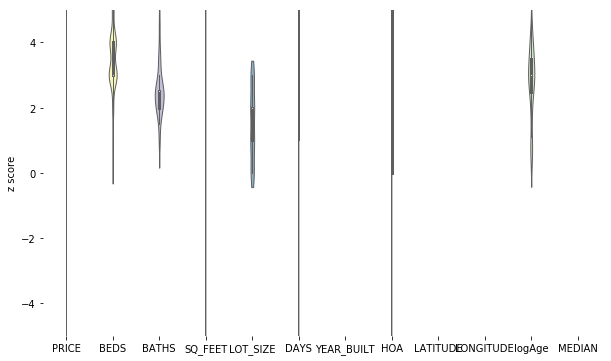

In [9]:
f, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=X[features],  
               palette="Set3", bw = .4, cut=1, linewidth=1)
ax.set(ylim=(-5, 5))
ax.set( ylabel='z score')
sns.despine(left=True, bottom=True)

In [21]:
house_data = load_dataframe()
features= ['ZIP', 'MLS','PRICE','BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']
house_data = house_data.dropna()
X = house_data[features]
y = house_data.PRICE

In [8]:
features= ['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS',
           'YEAR_BUILT']

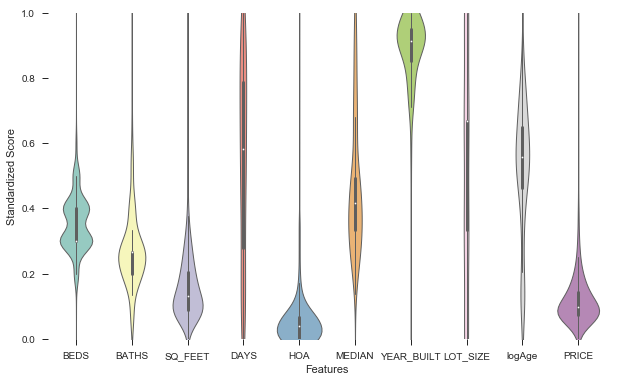

In [33]:
f, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=scaled_X,  
               palette="Set3", bw = .4, cut=1, linewidth=1)
ax.set(ylim=(0, 1))
ax.set( xlabel = 'Features', ylabel='Standardized Score')
sns.despine(left=True, bottom=True)

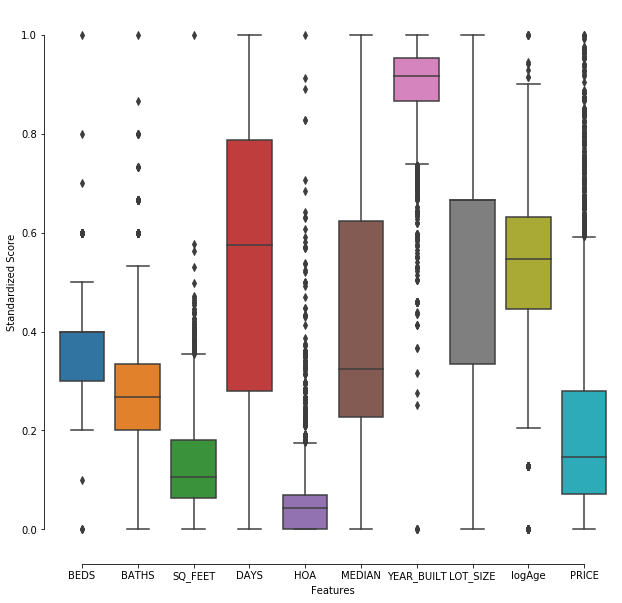

In [16]:
f, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(
            data=scaled_X)
ax.set( xlabel='Features', ylabel = "Standardized Score")
sns.despine(offset=10, trim=True)

NameError: name 'X_trans' is not defined

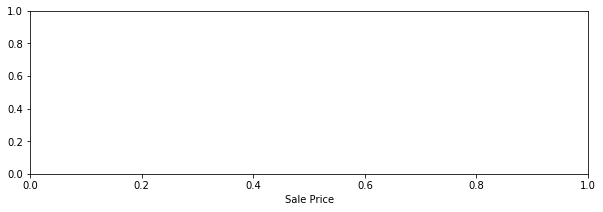

In [11]:
f, ax = plt.subplots(figsize=(10, 3))
ax.set( xlabel='Sale Price')
sns.boxplot( palette=["b", "g"], orient = 'h',
            data=X_trans['PRICE'])
sns.despine(offset=10, trim=True)

In [ ]:
f, ax = plt.subplots(figsize=(10, 3))
ax.set( xlabel='Sale Price')
sns.boxplot( palette=["b", "g"], orient = 'h',
            data=X['PRICE'])
sns.despine(offset=10, trim=True)

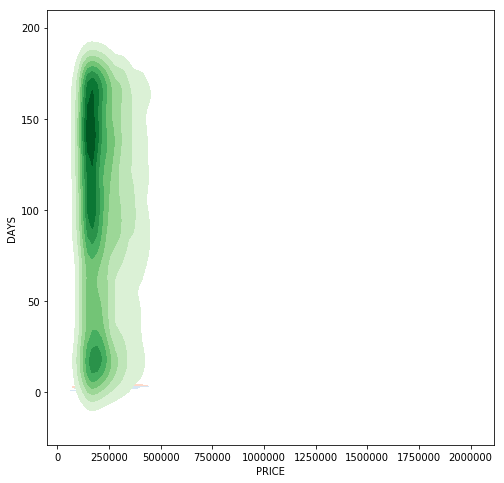

In [10]:
f, ax = plt.subplots(figsize=(8, 8))
#ax.set_aspect("equal")
ax = sns.kdeplot(X.PRICE, X.BATHS,
                 cmap="Blues", shade=True, shade_lowest=False)
ax = sns.kdeplot(X.PRICE, X.BEDS,
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(X.PRICE, X.DAYS,
                 cmap="Greens", shade=True, shade_lowest=False)



D:\Anaconda3_10\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


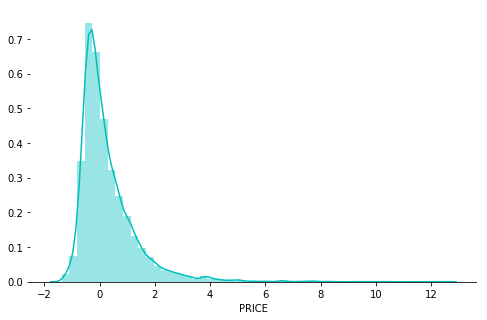

In [18]:
f, ax = plt.subplots(figsize=(8, 5))
sns.despine(left=True)
sns.distplot(X_trans.PRICE, color="c")

In [23]:
plt.show()

In [11]:
sns.set(style="ticks")
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.pairplot(X_trans[['BEDS','BATHS','SQ_FEET','LOT_SIZE','DAYS','YEAR_BUILT','MEDIAN','PRICE']]
            )
#sns.pairplot(X['BATHS','PRICE'], hue="BATHS")

NameError: name 'X_trans' is not defined

In [9]:
X.head()

,MLS,PRICE,BEDS,BATHS,SQ_FEET,LOT_SIZE,DAYS,YEAR_BUILT,HOA,LATITUDE,LONGITUDE,logAge,MEDIAN
0,21507042,295000.0,5.0,3.0,3892.0,2,167.0,1994.0,35.0,40.004712,-86.161206,3.218876,317906.0
1,21504853,346500.0,4.0,2.5,3923.0,2,139.0,1990.0,29.0,39.972871,-86.165201,3.367296,317906.0
2,21505003,965000.0,5.0,4.5,6768.0,2,139.0,2016.0,75.0,39.965305,-86.176621,1.098612,317906.0
3,21512685,400000.0,4.0,4.0,5124.0,3,127.0,1996.0,50.0,39.936647,-86.228057,3.135494,317906.0
4,21517865,501555.0,5.0,5.0,7732.0,3,125.0,2000.0,50.0,39.938926,-86.219860,2.944439,317906.0


In [8]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
feature_set= ['BEDS', 'BATHS', 'SQ_FEET','DAYS',
            'HOA', 'MEDIAN','YEAR_BUILT',"LOT_SIZE",'logAge', 'PRICE']
scaler = MinMaxScaler()
df2 = X[feature_set]
transformer = min_max_scaler.fit(df2)
scaled_X = pd.DataFrame(transformer.transform(df2), index=df2.index, columns=df2.columns)

In [18]:
scaled_X = scaled_X.dropna()

In [10]:
scaled_X.head()

,BEDS,BATHS,SQ_FEET,DAYS,HOA,MEDIAN,YEAR_BUILT,LOT_SIZE,logAge,PRICE
0,0.5,0.333333,0.203034,0.927374,0.062612,0.779435,0.889908,0.666667,0.597297,0.257353
1,0.4,0.266667,0.205096,0.770950,0.051878,0.779435,0.871560,0.666667,0.624838,0.333088
3,0.4,0.466667,0.284992,0.703911,0.089445,0.779435,0.899083,1.000000,0.581825,0.411765
4,0.5,0.600000,0.458489,0.692737,0.089445,0.779435,0.917431,1.000000,0.546372,0.561110
5,0.3,0.400000,0.307477,0.748603,0.033989,0.779435,0.839450,1.000000,0.664960,0.535294


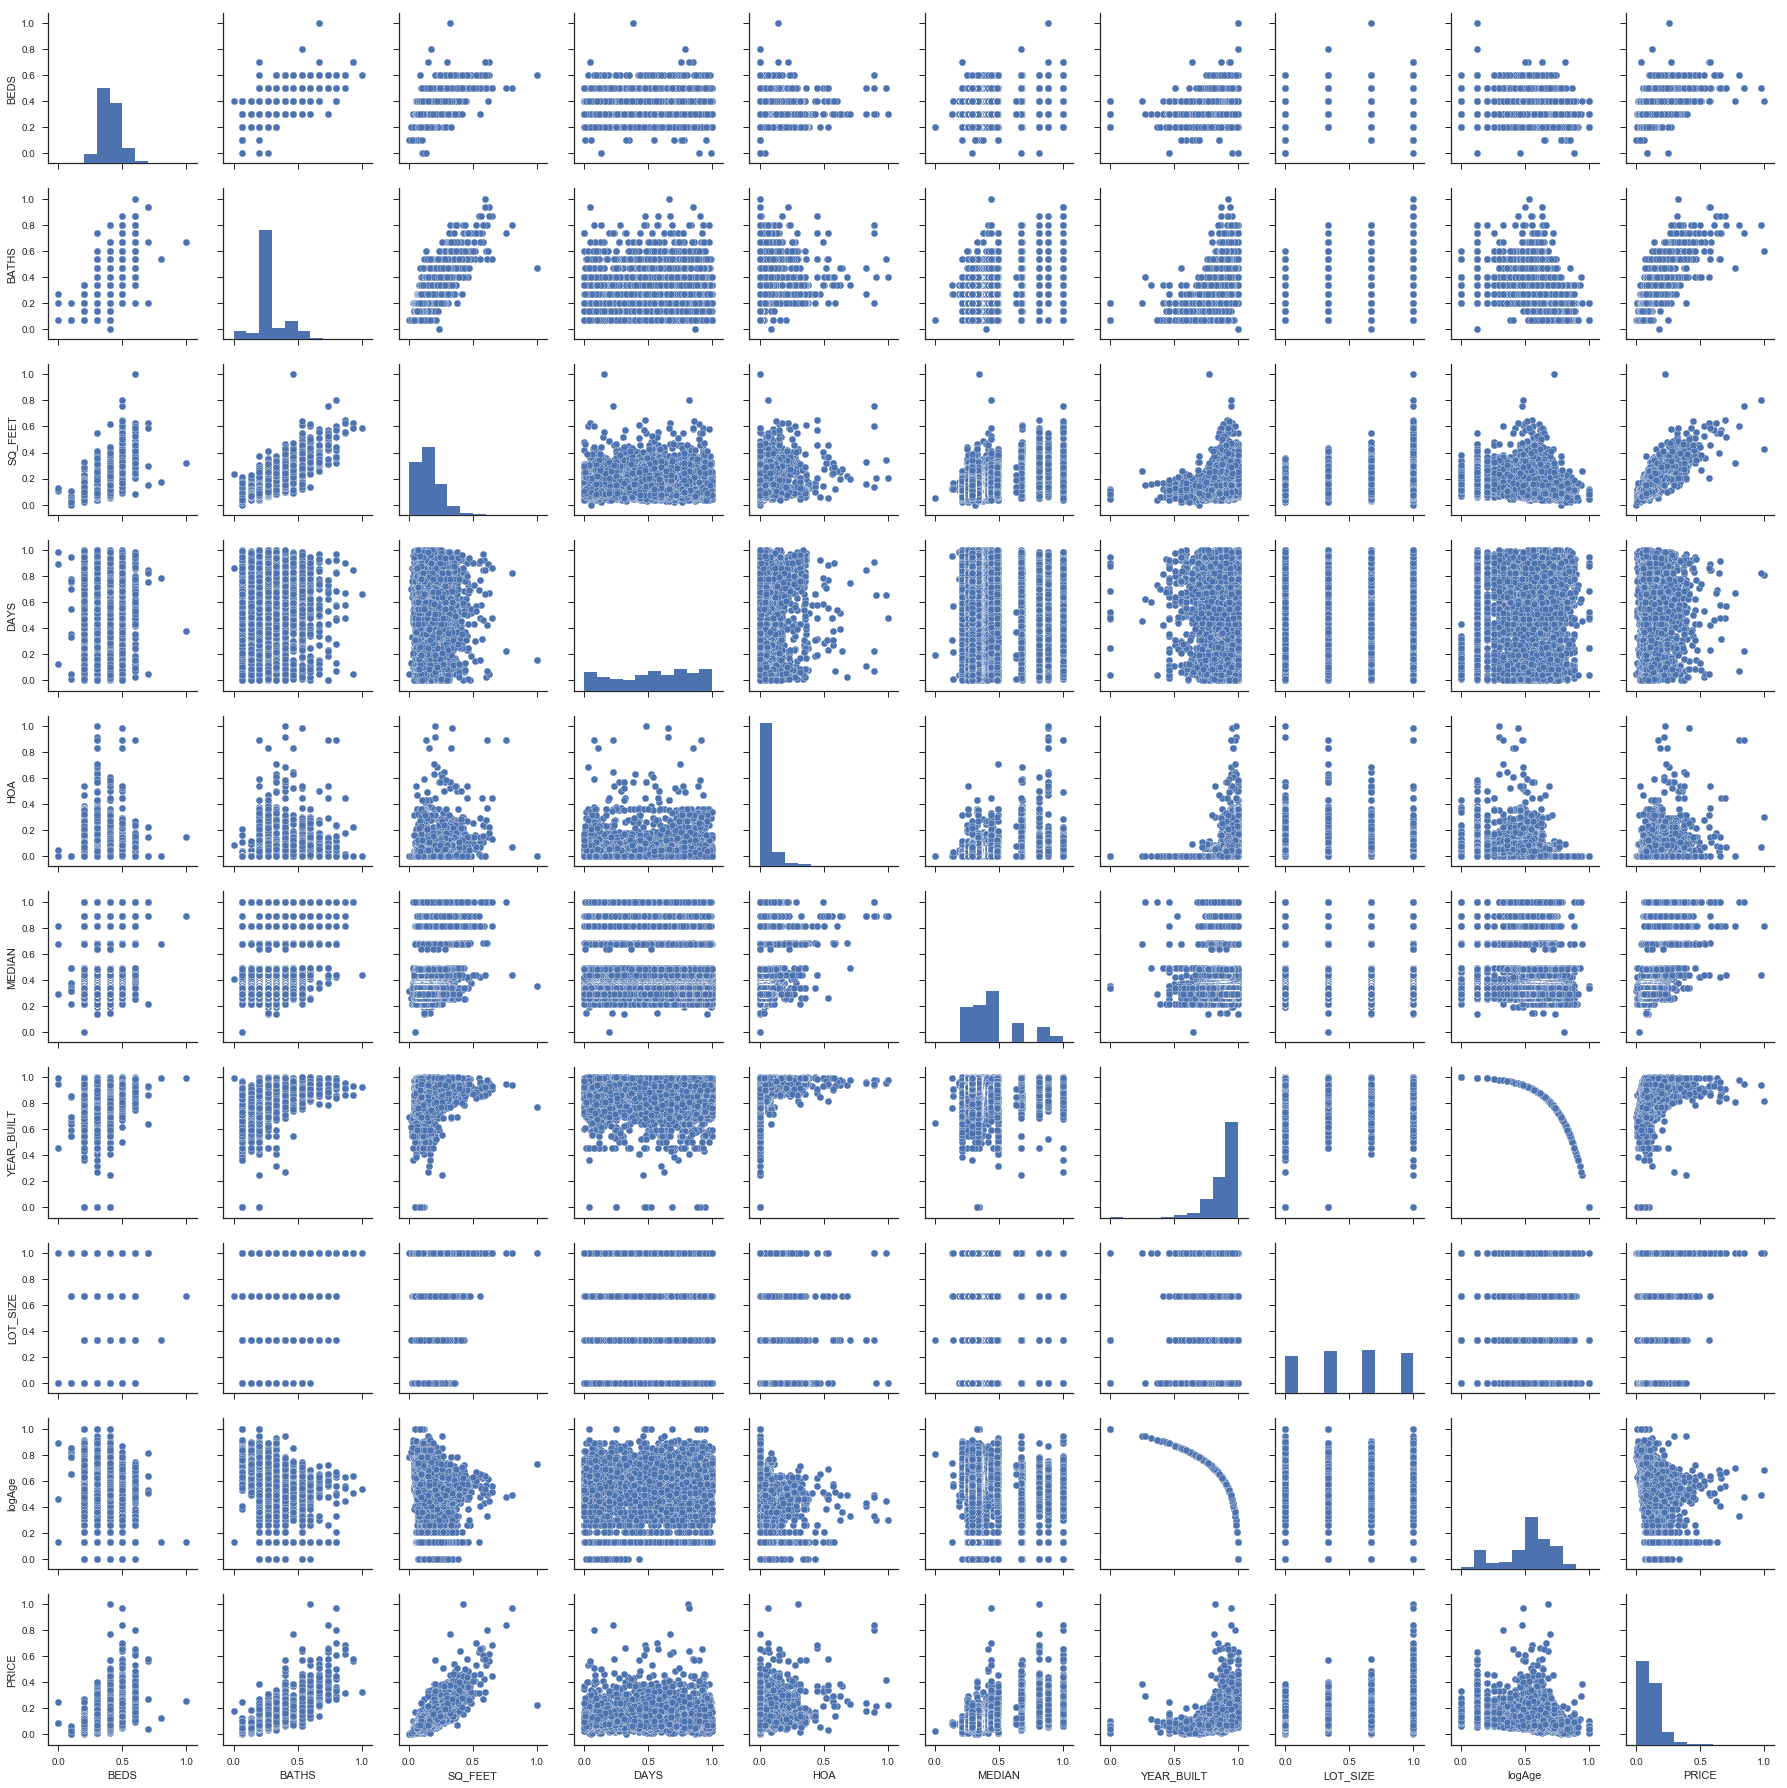

In [29]:
sns.set(style="ticks")
#colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.pairplot(scaled_X[feature_set])

In [30]:
corr = scaled_X.corr()

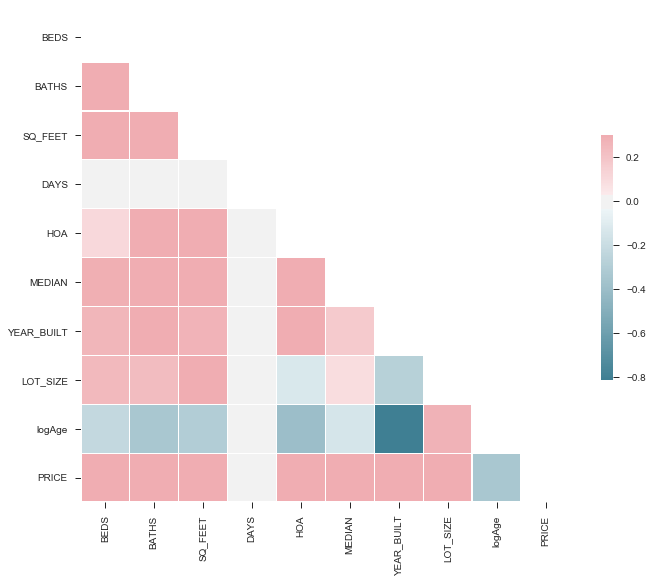

In [31]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})